# Isopy in action!
Testing Isopy's three functions using data from Argo float products

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data Ser...

In [3]:
# %load ../isopy/isopy.py
import numpy as np
import xarray as xr
from scipy import interpolate

def compute_iso(data, iso, lev, d_or_t):

    """ compute the depth of some isopycnal/isotherm.
    
    Parameters:
    ----------------
    
    data: the input variable (Temperature, Density),
        array_like (3D), shape (N, M, L).
    iso: the objective isosurface layer,
        float.
    lev: the vertical depth,
        array_like (1D), shape (N).
    d_or_t: input d or t for density or temperature (lowercase)
        string
        
    Returns:
    ----------------
    
    var_iso: the output variable,
        array_like (2D), shape (M, L).
        
    """
    size = data.shape
    L = size[2]
    M = size[1]
    N = size[0] #this should be the same length as lev
    
    #check that the input data is in the for depth lat lon (or depth lon lat)
    if len(lev) != N:
        print('Error: either data input variable does not have depth as dimension 0, or lev variable is not same length as depth')
    else:
        if d_or_t in {'d','t'} :
            var_iso = np.zeros((M, L)) # define the output var
            var_iso[:, :] = np.nan # NaN fill to avoid any later computation errors with zeros

            for i in np.arange(L): #loop through dimension 1
                for j in np.arange(M): #loop through dimension 2

                    data_prof = data[:, j, i] #select one profile
                    if d_or_t == 'd':
                        id1 = np.where(data_prof < iso)
                        if np.size(id1) > 0 and np.size(id1) < len(z):
                            var1 = data_prof[id1[0][-1]]
                            var2 = data_prof[id1[0][-1] + 1]
                            if var1 < var2:
                                func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                                var_iso[j, i] = func(iso)

                    else:
                        id1 = np.where(data_prof > iso)

                        if np.size(id1) > 0 and np.size(id1) < len(z):

                            var1 = data_prof[id1[0][-1]]
                            var2 = data_prof[id1[0][-1] + 1]

                            if var1 > var2:
                                func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                                var_iso[j, i] = func(iso)

        else:
            print('Is this density or temperature?')
    return var_iso

def iso_val(density_data, ts_data, iso):

    """ compute temperature or salinity along some isopycnal/isotherm.
    
    Parameters:
    ----------------
    
    density_data: density input,
        array_like (3D), shape (N, M, L).
    ts_data: temp or salt input,
        array_like (3D), shape (N, M, L).
    iso: the objective isosurface layer,
        float.
        
    Returns:
    ----------------
    
    ts_iso: the output variable,
        array_like (2D), shape (M, L).
        
    """
    size = density_data.shape
    L = size[2]
    M = size[1]
    N = size[0]
    
    ts_iso = np.zeros((M, L)) # define the output var
    ts_iso[:, :] = np.nan # NaN fill to avoid any later computation errors with zeros
    
    dens = xr.DataArray(density_data)
    var = xr.DataArray(ts_data)
    a = dens.where(dens.min(axis=0)<iso)
    b = var.where(dens.min(axis=0)<iso) 

    for j in range(M):
        for k in range(L):
            x = a[:,j,k]
            y = b[:,j,k]
            f = interpolate.interp1d(x.values,y.values,'linear')
            ts_iso[j,k] = f(iso)
            
    return ts_iso

def iso_average(data, var_iso, lev):
    
    """ compute vertical average above the objective isopycnal layer
    
    Parameters:
    ----------------
    
    data: the input variable (temperature, salinity, U, V),
        array_like (3D), shape (N, M, L).   
    var_iso: the isopycnal layer,
        array_like (2D), shape (M, L).

    lev: the vertical depth,
        array_like (1D), shape (N).
        
    Returns:
    ----------------
    
    var_ave: the output variable,
        array_like (2D), shape (M, L).
    
    """
    
    size = data.shape
    L = size[2]
    M = size[1]
    N = size[0]
    
    data_new = (data[:-1, :, :] + data[1:, :, :]) / 2
    dz = lev[1:] - lev[:-1]

    var_out = np.zeros((M, L))
    var_out[:, :] = np.NaN
    
    for i in np.arange(L): #loop through dimension 1
        for j in np.arange(M): #loop through dimension 2
            
            var1 = data_new[:, j, i] * dz
            idx = find_nearest(lev, dep_iso[j, i])
        
            if idx > 0:
                var_out[j, i] = np.nansum(var1[:idx]) / np.sum(dz[:idx])
    return var_out
                
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



## Test Cell for Func 1: `compute_iso`

In [4]:
%%time

# read density, temp, salinity
pden = ds.pden #.chunk(chunks={'lat' : 30, 'lon' : 30})
temp = ds.temp
salt = ds.salt
z = pden.lev.values
iso = [25]

for t in np.arange(1):
    # isopycnal depth
    data0 = pden[90, :, :].values
    dep_iso = compute_iso(data0, iso, z, 'd')
    
    # now, try isothermal depth
    data1 = temp[90, :, :].values
    temp_iso = compute_iso(data1, iso, z, 't')



/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater


CPU times: user 4.63 s, sys: 138 ms, total: 4.77 s
Wall time: 11.3 s


## Now, Let's plot it in Cartopy

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def make_map(projection=ccrs.PlateCarree(), figsize=(20, 15)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={"projection": projection})
    return fig, ax

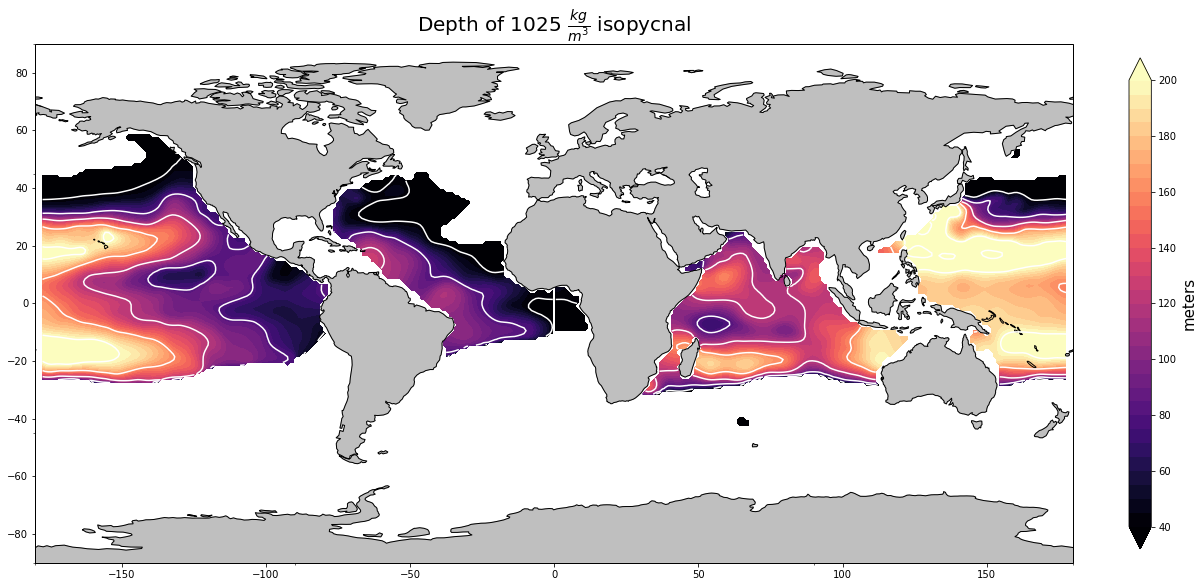

In [70]:
fig, ax = make_map(projection=ccrs.PlateCarree(), figsize=(20,15))
ax.set_global()
ax.coastlines(resolution="110m", color="k")
ax.add_feature(cfeature.LAND, facecolor="0.75")

lat = ds.lat.values
lon = ds.lon.values
lons, lats = np.meshgrid(lon, lat)

h = ax.contourf(lons, lats, dep_iso, np.arange(40, 201, 5), extend='both', trans=ccrs.PlateCarree(), cmap='magma')
ax.contour(lons, lats, dep_iso, trans=ccrs.PlateCarree(), colors='w')

plt.colorbar(h, orientation='vertical', fraction=0.02).set_label(label='meters', size=15)

ax.set_title('Depth of 1025 $\\frac{kg}{m^{3}}$ isopycnal', size=20)
ax.set_xticks(np.linspace(-180, 180, 5), ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 5), ccrs.PlateCarree());

## Now, let's try hvplot

In [9]:
# change numpy to Xarray
ds_dep_iso = xr.DataArray(dep_iso, coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
ds_dep_iso

<xarray.DataArray (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [10]:
import hvplot.xarray
import geoviews as gv
import holoviews as hv
from holoviews import opts

In [75]:
proj = ccrs.PlateCarree()
ds_dep_iso.hvplot.quadmesh(
    'lon', 'lat', projection=proj, project=True, global_extent=True,
    width=900, height=540, cmap='magma_r', rasterize=True, dynamic=False
) * gv.feature.coastline * gv.feature.land(color='red')

:Overlay
   .Image.I     :Image   [lon,lat]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]
   .Land.I      :Feature   [Longitude,Latitude]

## Test Cell for Func 2: `iso_val`

In [17]:
%%time
isotemp = iso_val(pden[90, :, :].values, temp[90, :, :].values, iso)
isosalt = iso_val(pden[90, :, :].values, salt[90, :, :].values, iso)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


CPU times: user 1min 6s, sys: 255 ms, total: 1min 7s
Wall time: 1min 22s


## Now, Let's plot it in Cartopy

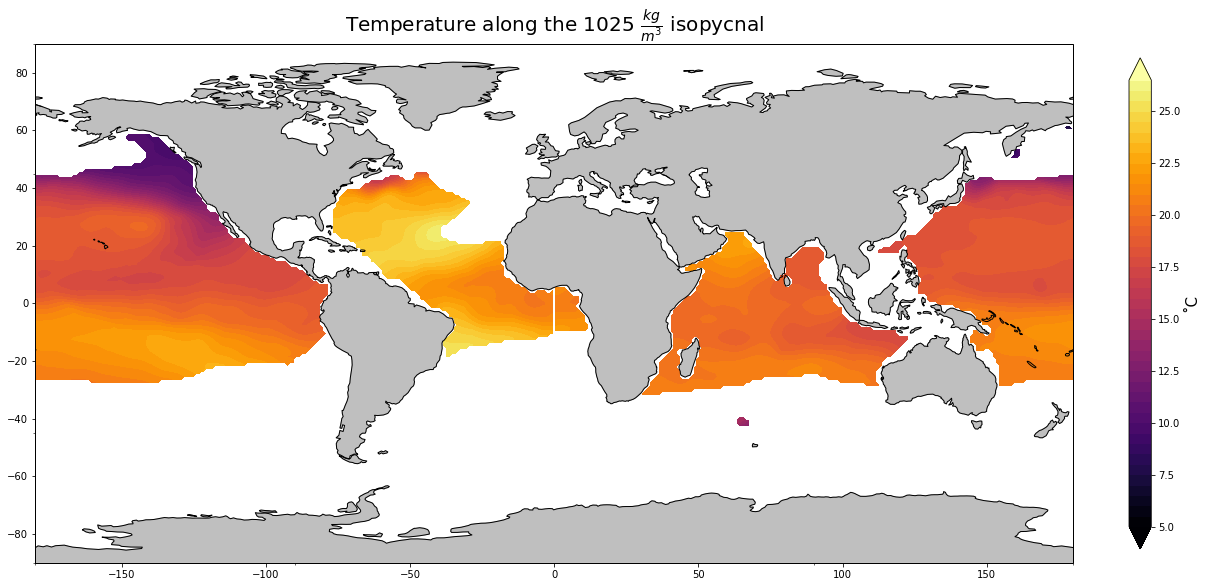

In [77]:
fig, ax = make_map(projection=ccrs.PlateCarree(), figsize=(20,15))
ax.set_global()
ax.coastlines(resolution="110m", color="k")
ax.add_feature(cfeature.LAND, facecolor="0.75")

lat = ds.lat.values
lon = ds.lon.values
lons, lats = np.meshgrid(lon, lat)

h1 = ax.contourf(lons, lats, isotemp, np.arange(5,27,0.5),extend='both', trans=ccrs.PlateCarree(), 
                                                                     cmap='inferno', vmin=5, vmax=27) 

plt.colorbar(h1, orientation = 'vertical', fraction=0.02, label='˚C').set_label(label='˚C', 
                                                                                #weight='bold',
                                                                                size=15)
ax.set_title('Temperature along the 1025 $\\frac{kg}{m^{3}}$ isopycnal', size=20)
ax.set_xticks(np.linspace(-180, 180, 5), ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 5), ccrs.PlateCarree());

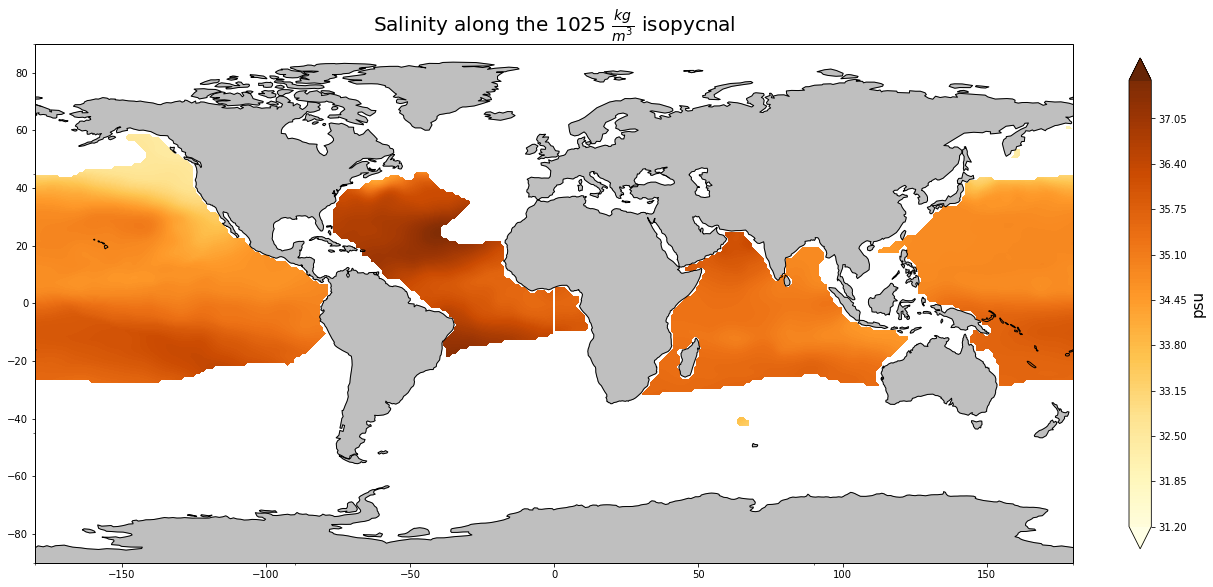

In [54]:
fig, ax = make_map(projection=ccrs.PlateCarree(), figsize=(20,15))
ax.set_global()
ax.coastlines(resolution="110m", color="k")
ax.add_feature(cfeature.LAND, facecolor="0.75")

lat = ds.lat.values
lon = ds.lon.values
lons, lats = np.meshgrid(lon, lat)

h1 = ax.contourf(lons, lats, isosalt, np.arange(31.2, 37.6 ,0.05),extend='both', trans=ccrs.PlateCarree(), 
                                                                        cmap='YlOrBr', vmin=31, vmax=38)
plt.colorbar(h1, orientation = 'vertical', fraction=0.02, label='˚C').set_label(label='psu', 
                                                                                #weight='bold',
                                                                                size=15)
ax.set_title('Salinity along the 1025 $\\frac{kg}{m^{3}}$ isopycnal', size=20)
ax.set_xticks(np.linspace(-180, 180, 5), ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 5), ccrs.PlateCarree());

## Test Cell for Func 3: `iso_average`

In [56]:
temp_avr = iso_average(temp[90, :, :].values, temp_iso, ds.lev.values)
temp_avr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

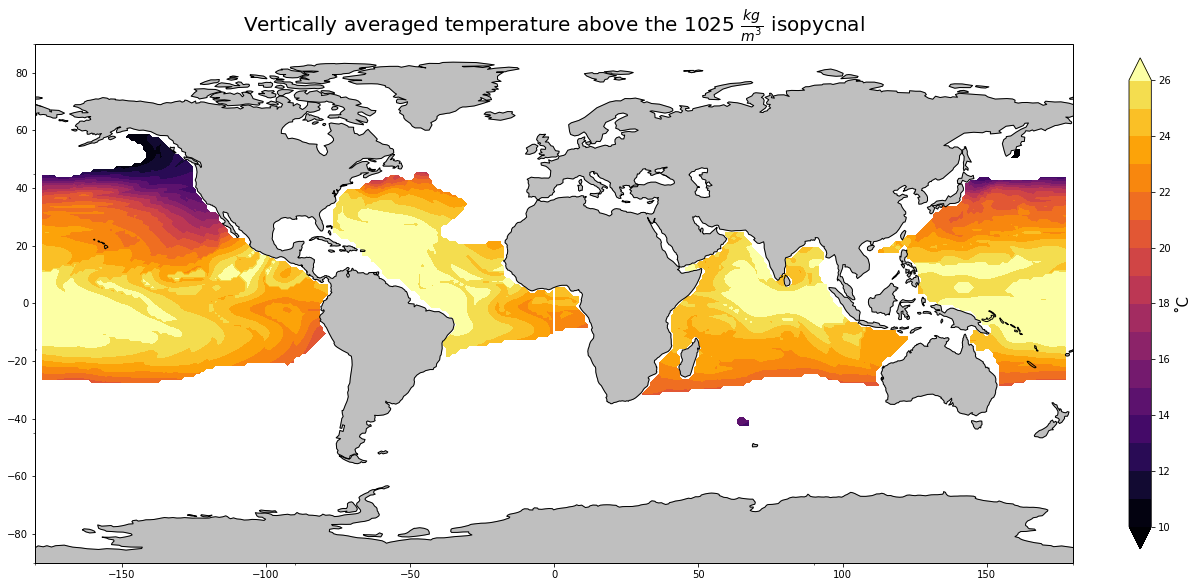

In [79]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

def make_map(projection=ccrs.PlateCarree(), figsize=(20, 15)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={"projection": projection})
    return fig, ax

fig, ax = make_map(projection=ccrs.PlateCarree(), figsize=(20,15))

ax.set_global()
ax.coastlines(resolution="110m", color="k")
ax.add_feature(cfeature.LAND, facecolor="0.75")

lat = ds.lat.values
lon = ds.lon.values

h2 = ax.contourf(lon, lat, temp_avr, np.arange(10,27,1), extend='both', trans=ccrs.PlateCarree(), 
                                                                 cmap='inferno', vmin=10,vmax=27)
plt.colorbar(h2, orientation = 'vertical', fraction=0.02).set_label(label='˚C', size=15)

ax.set_xticks(np.linspace(-180, 180, 5), ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 5), ccrs.PlateCarree())
ax.set_title('Vertically averaged temperature above the 1025 $\\frac{kg}{m^{3}}$ isopycnal', size=20);

# Thank You

Laura: lkg2133@columbia.edu, 

Tongya: tl2913@columbia.edu, 

Shanice: stb2145@columbia.edu,

Kexin: kexin.song@rsmas.miami.edu
